In [46]:
# bids_dir = 'C:\\Users\\Remi\\Documents\\McGurk\\rawdata'
bids_dir = '/data/rawdata'
# output_dir = 'C:\\Users\\Remi\\Documents\\McGurk\\derivatives\\art_repair'
output_dir = '/output/'

time_repetition = 2.56
num_slices = 42
time_acquisition = time_repetition - (time_repetition/num_slices);
slice_order = list(range(0,42,1)) 
ref_slice = 1

anat_file = '/data/rawdata/rawdata/sub-01/anat/sub-01_T1w.nii.gz'
func_file = '/data/rawdata/rawdata/sub-01/func/sub-01_task-contextmcgurk_run-01_bold.nii.gz'

In [44]:
! ls /data/rawdata/rawdata/sub-01/func/sub-01_task-contextmcgurk_run-01_bold.nii.gz

sub-01_task-contextmcgurk_run-01_bold.nii.gz
sub-01_task-contextmcgurk_run-01_events.tsv
sub-01_task-contextmcgurk_run-02_bold.nii.gz
sub-01_task-contextmcgurk_run-02_events.tsv
sub-01_task-contextmcgurk_run-03_bold.nii.gz
sub-01_task-contextmcgurk_run-03_events.tsv
sub-01_task-contextmcgurk_run-04_bold.nii.gz
sub-01_task-contextmcgurk_run-04_events.tsv
sub-01_task-contextmcgurk_run-05_bold.nii.gz
sub-01_task-contextmcgurk_run-05_events.tsv
sub-01_task-contextmcgurk_run-06_bold.nii.gz
sub-01_task-contextmcgurk_run-06_events.tsv
sub-01_task-contextmcgurk_run-07_bold.nii.gz
sub-01_task-contextmcgurk_run-07_events.tsv
sub-01_task-contextmcgurk_run-08_bold.nii.gz
sub-01_task-contextmcgurk_run-08_events.tsv


In [28]:
from builtins import range
from nipype.algorithms.misc import Gunzip
import nipype.interfaces.io as nio  # Data i/o
import nipype.interfaces.spm as spm  # spm
import nipype.interfaces.fsl as fsl  # fsl
import nipype.interfaces.matlab as mlab  # how to run matlab
import nipype.interfaces.utility as util  # utility
import nipype.pipeline.engine as pe  # pypeline engine
import nipype.algorithms.modelgen as model  # model specification
import os  # system functions

In [29]:
# Set the way matlab should be called
mlab.MatlabCommand.set_default_matlab_cmd("matlab -nodesktop -nosplash")

In [31]:
unzip_anat = pe.Node(Gunzip(), 
                name='unzip_anat')

unzip_func = pe.Node(Gunzip(), 
                name='unzip_func')

realign = pe.Node(interface=spm.Realign(), name="realign")

coregister = pe.Node(interface=spm.Coregister(), name="coregister")
coregister.inputs.jobtype = 'estimate'

segment = pe.Node(interface=spm.Segment(), name="segment")
segment.inputs.gaussians_per_class = [1, 1, 1, 4]

normalize_func = pe.Node(interface=spm.Normalize(), name="normalize_func")
normalize_func.inputs.jobtype = "write"

normalize_struc = pe.Node(interface=spm.Normalize(), name="normalize_struc")
normalize_struc.inputs.jobtype = "write"

smooth = pe.Node(interface=spm.Smooth(), name="smooth")

In [32]:
def get_vox_dims(volume):
    import nibabel as nb
    from nipype.utils import NUMPY_MMAP
    if isinstance(volume, list):
        volume = volume[0]
    nii = nb.load(volume, mmap=NUMPY_MMAP)
    hdr = nii.header
    voxdims = hdr.get_zooms()
    return [float(voxdims[0]), float(voxdims[1]), float(voxdims[2])]

In [37]:
preproc = pe.Workflow(name='preproc_spm', base_dir=output_dir)

In [38]:
preproc.connect([
    (unzip_func, realign, [('out_file', 'in_files')]),
    (unzip_anat, coregister, [('out_file', 'source')]),
    (realign, coregister, [('mean_image', 'target')]),
    (coregister, segment, [('coregistered_source', 'data')]),
    (segment, normalize_func, [('transformation_mat', 'parameter_file')]),
    (segment, normalize_struc,
     [('transformation_mat', 'parameter_file'), ('modulated_input_image',
                                                 'apply_to_files'),
      (('modulated_input_image', get_vox_dims), 'write_voxel_sizes')]),
    (realign, normalize_func, [('realigned_files', 'apply_to_files'),
                               (('realigned_files', get_vox_dims),
                                'write_voxel_sizes')]),
    (normalize_func, smooth, [('normalized_files', 'in_files')]),
    ])

181112-13:51:48,396 nipype.workflow INFO:
	 Generated workflow graph: /output/preproc_spm/test_prepro_spm_graph.png (graph2use=orig, simple_form=True).


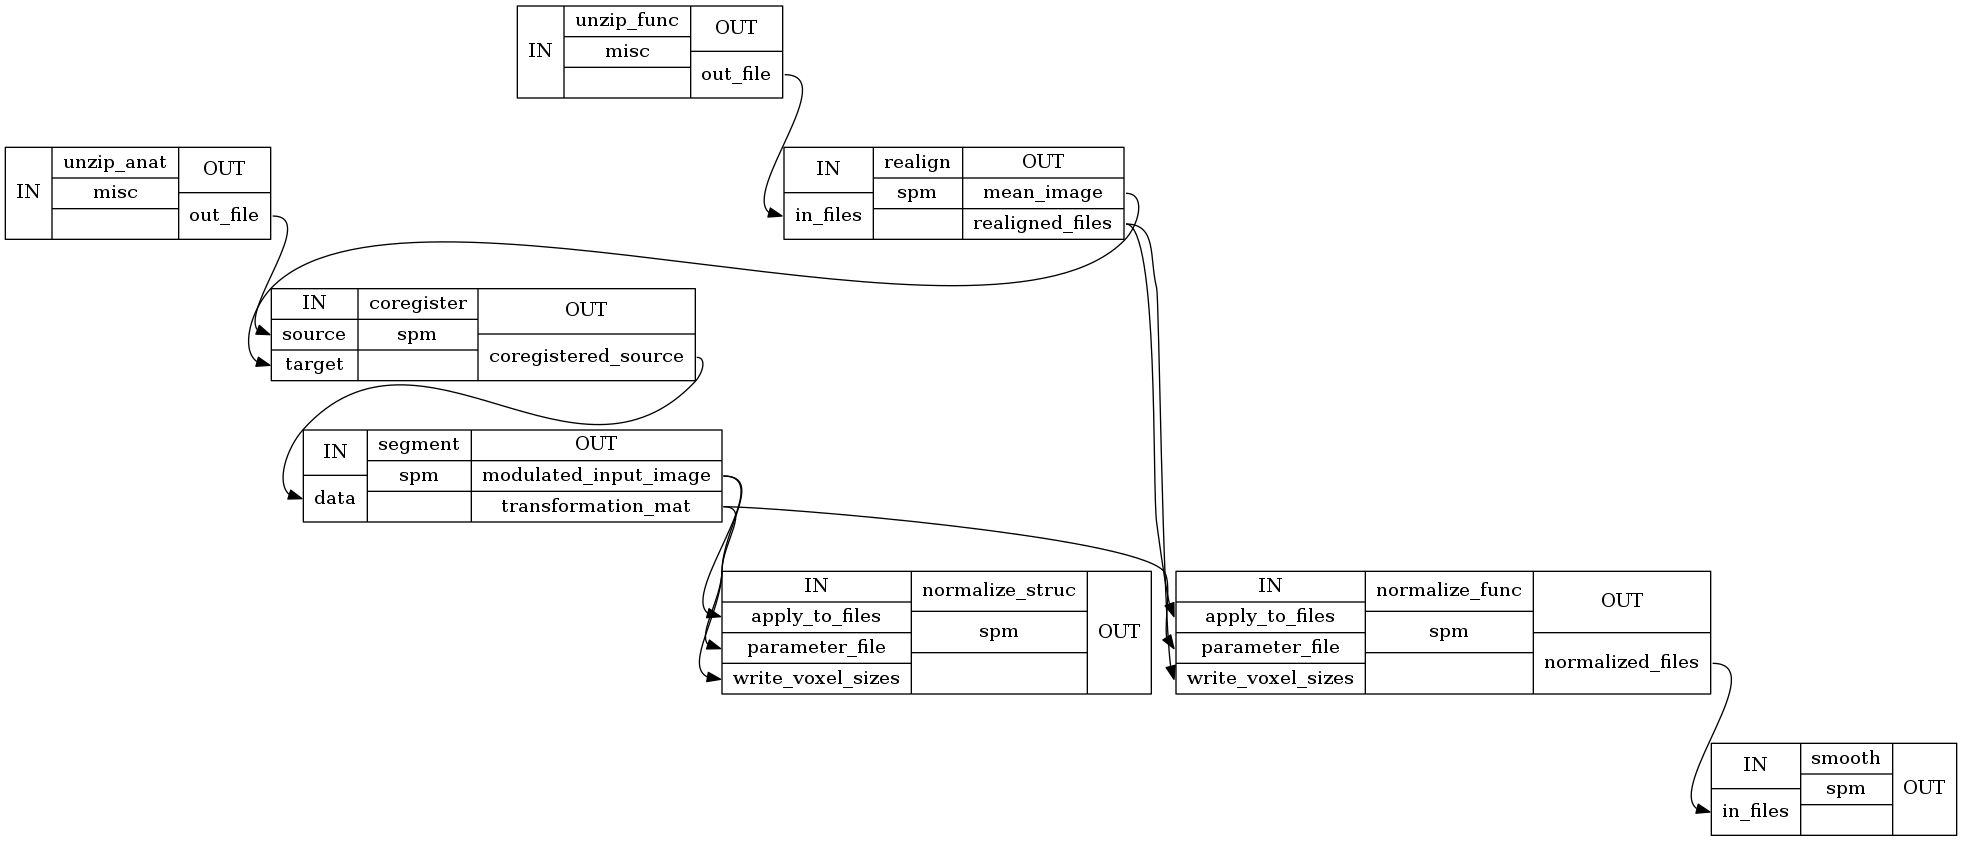

In [39]:
graph_name = os.path.join(preproc.base_dir, preproc.name, 'test_prepro_spm_graph.png')
detailed_graph_name = os.path.join(preproc.base_dir, preproc.name, 'test_prepro_spm_graph_detailed.png')
graph_type = 'orig'

preproc.write_graph(graph2use=graph_type, dotfilename=graph_name)
from IPython.display import Image
# Image(filename=graph_name)
Image(filename=detailed_graph_name)

In [47]:
unzip_func.inputs.in_file = func_file
unzip_anat.inputs.in_file = anat_file
res = preproc.run()

181112-13:57:49,904 nipype.workflow INFO:
	 Workflow preproc_spm settings: ['check', 'execution', 'logging', 'monitoring']
181112-13:57:50,32 nipype.workflow INFO:
	 Running serially.
181112-13:57:50,51 nipype.workflow INFO:
	 [Node] Setting-up "preproc_spm.unzip_anat" in "/output/preproc_spm/unzip_anat".
181112-13:57:50,133 nipype.workflow INFO:
	 [Node] Running "unzip_anat" ("nipype.algorithms.misc.Gunzip")
181112-13:57:53,0 nipype.workflow INFO:
	 [Node] Finished "preproc_spm.unzip_anat".
181112-13:57:53,13 nipype.workflow INFO:
	 [Node] Setting-up "preproc_spm.unzip_func" in "/output/preproc_spm/unzip_func".
181112-13:57:53,87 nipype.workflow INFO:
	 [Node] Running "unzip_func" ("nipype.algorithms.misc.Gunzip")
181112-13:58:08,360 nipype.workflow INFO:
	 [Node] Finished "preproc_spm.unzip_func".
181112-13:58:08,373 nipype.workflow INFO:
	 [Node] Setting-up "preproc_spm.realign" in "/output/preproc_spm/realign".
181112-13:58:13,360 nipype.workflow INFO:
	 [Node] Running "realign" ("

RuntimeError: Workflow did not execute cleanly. Check log for details